# Priprema

```
pip install pandas==0.24.2
pip install statsmodels==0.10.2
pip install tensorflow==2.0.0
pip install fbprophet==0.5
```

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARIMAResults, ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAXResults, SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import tensorflow as tf
from tensorflow.python.keras.models import Sequential, load_model, Model
from tensorflow.python.keras.layers import LSTM, GRU, Bidirectional, TimeDistributed, Flatten, MaxPooling1D, Conv1D, ConvLSTM2D, Layer, BatchNormalization, RepeatVector
from tensorflow.python.keras.layers import Dense, Dropout, Input, Add, Activation, ZeroPadding1D, AveragePooling1D
from tensorflow.python.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

plt.rcParams["font.size"] = 12.0
plt.rcParams["date.autoformatter.year"] = "%Y"
plt.rcParams["date.autoformatter.month"] = "%m.%Y"
plt.rcParams["date.autoformatter.day"] = "%d.%m.%Y"
plt.rcParams["date.autoformatter.hour"] = "%d.%m %H"
plt.rcParams["date.autoformatter.minute"] = "%d %H:%M"
plt.rcParams["date.autoformatter.second"] = "%H:%M:%S"
plt.rcParams["date.autoformatter.microsecond"] = "%M:%S.%f"

In [2]:
global _texts
_texts = list()

def calculate_stats(real, predictions):

    if predictions is None:
        return None, None, None

    mae = mean_absolute_error(real, predictions)
    mae = round(mae, 2)

    # FA (Forecasting Attainment)
    fa = sum(np.array(predictions).flatten()) / sum(np.array(real).flatten())
    if isinstance(fa, (list, tuple, np.ndarray)):
        fa = fa[0]

    fa = round(fa, 2)

    return mae, fa

def _show_texts():
    global _texts

    df = pd.DataFrame(_texts).sort_values("y")

    prev_y = None

    for index, row in df.iterrows():

        y = row["y"]

        if prev_y is not None and (prev_y > y or prev_y - y < 5):
            y = prev_y + 5

        plt.text(row["x"], y, row["text"], color=row["color"])
        prev_y = y

    _texts = list()

def plot_ts(ts, title="Rezervacije 01.07.", xlab="Datum", ylab="Broj soba"):
    plt.figure(figsize=(18, 10), dpi=100)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.tight_layout()
    plt.plot(ts)
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    
    
def plot_predict(ts, mtpl_predictions):
    global _texts
    
    legend = list(["y (train)", "y (test)"])
    colors = ["#9C27B0", "#F44336", "#FFC107"]

    plt.plot(ts.iloc[:-60].y, label="y (train)", color="#2196F3", alpha=0.5)
    plt.plot(ts.iloc[-60:].y, label="Real (test)", color="#00E676", alpha=0.5)

    longest_predictions = None
    title_info = ""

    for i, gap_pred in enumerate(mtpl_predictions):

        gap, predictions = gap_pred['gap'], gap_pred['predictions']

        if longest_predictions is None or len(predictions) > len(longest_predictions):
            longest_predictions = predictions

        test_l = ts[-gap:]

        mae, fa = calculate_stats(test_l.y.values, predictions)

        plt.plot(test_l.index, predictions, label="y" + str(gap), color=colors[i])
        
        x = test_l.index[-1] + datetime.timedelta(days=5)
        y = predictions[-1][0] if type(predictions[-1]) is list else predictions[-1]
        text = "MAE: " + str(mae) + ", FA: " + str(fa)
        _texts.append(dict({"x": x, "y": y, "text": text, "color": colors[i]}))

        legend.append("Forecast (" + test_l.index[0].strftime("%d.%m") + " - " + test_l.index[-1].strftime("%d.%m") + ")")

    mn = ts.iloc[-60:].index[0] - datetime.timedelta(50) 
    mx = ts.iloc[-60:].index[-1] + datetime.timedelta(30)
    plt.axis([mn, mx, 0, max([max(predictions)*1.1, max(ts[mn:mx].y.values)*1.2])])
        
    _show_texts()
    plt.legend(legend, loc="best")
    plt.xlabel("Datum")
    plt.ylabel("Broj soba")
    plt.title("Predviđanje broja rezervacija")# (" + title_info[:-2] + ")")

    # Fix for overlaping ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(len(ax.xaxis.get_major_ticks()) - len(mtpl_predictions) - 1))

    plt.rcParams["figure.figsize"] = (18, 10)
    plt.tight_layout()
    plt.show()
    

# Rezervacije

In [3]:
ts = pd.read_csv("data/reservations_01_07.csv", index_col=[0])
ts.index = pd.to_datetime(ts.index)

In [4]:
ts.head()

,y
X,
2015-07-01,10
2015-07-02,13
2015-07-03,7
2015-07-04,8
2015-07-05,2


/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


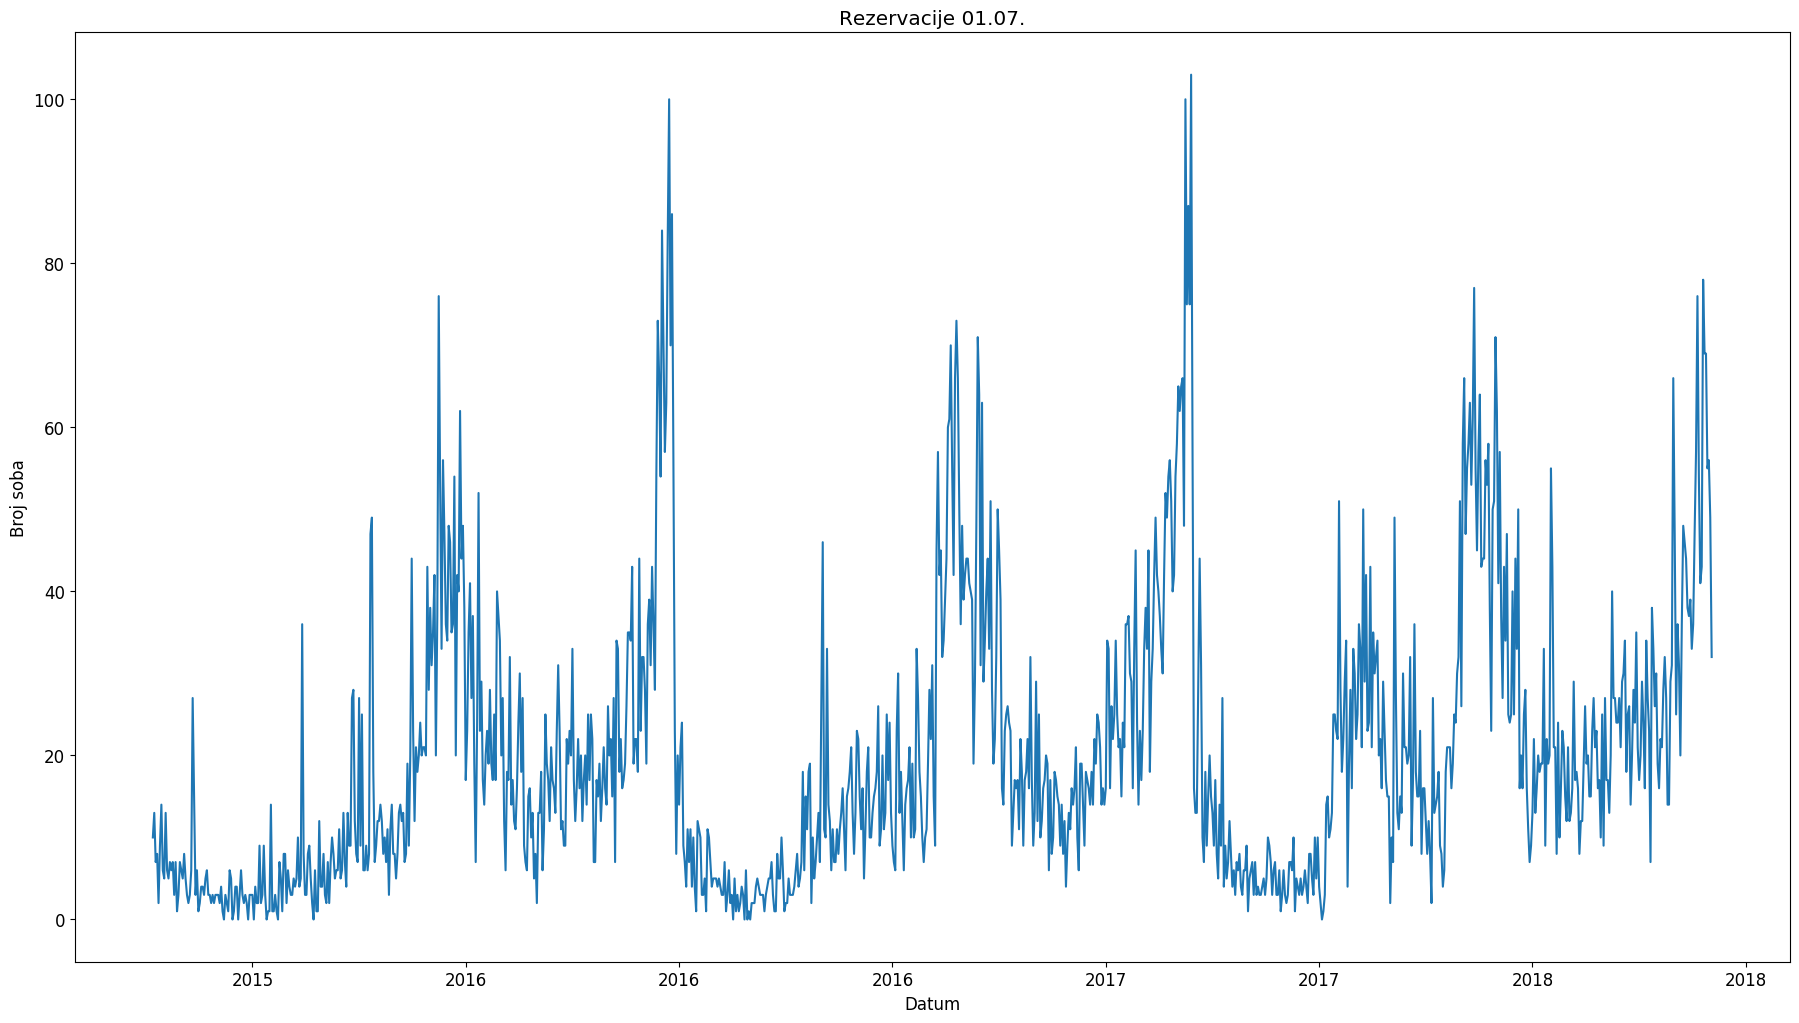

In [5]:
plot_ts(ts)

In [8]:
# Train & test split

train_60 = ts.iloc[:-60]
test_60 = ts.iloc[-60:]
train_30 = ts.iloc[:-30]
test_30 = ts.iloc[-30:]
train_7 = ts.iloc[:-7]
test_7 = ts.iloc[-7:]

# Naive/Persistent

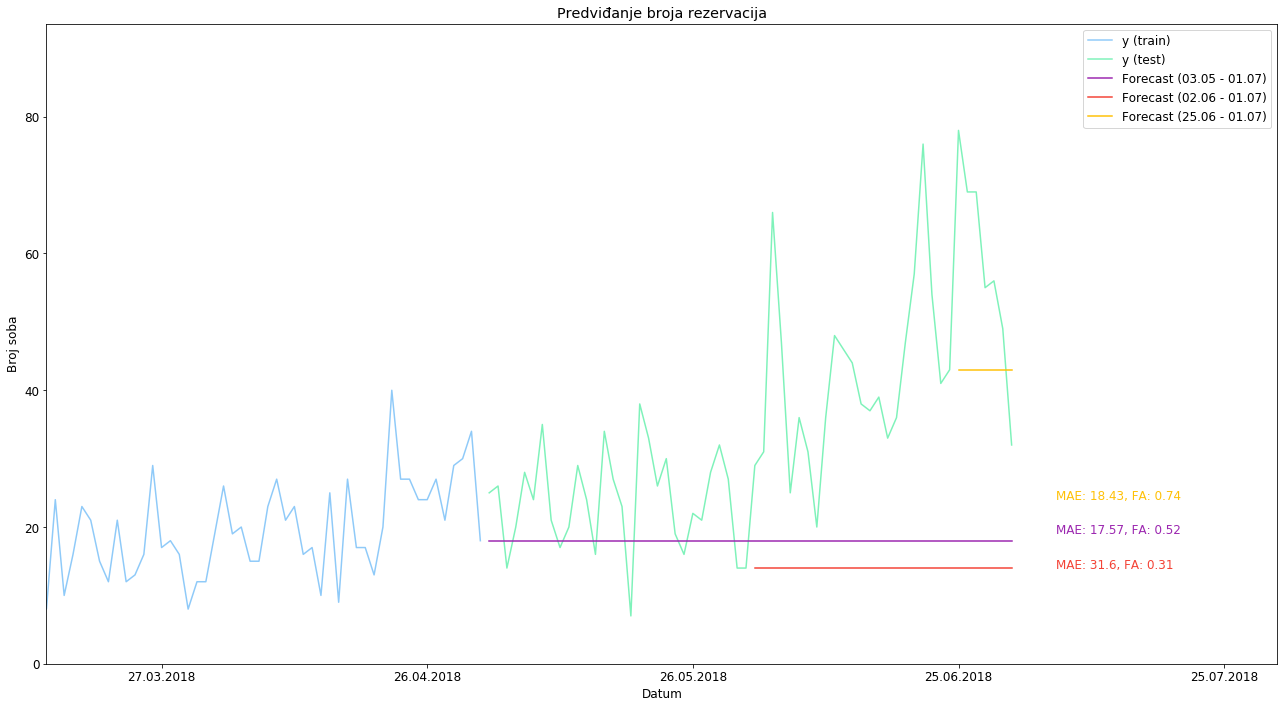

In [10]:
predictions = list()
for t, g in zip([train_60, train_30, train_7], [60, 30, 7]):
    p = np.repeat(t.y.values[-1], g)
    predictions.append({"gap": g, "predictions": p})
    
plot_predict(ts, predictions)

# Seasonal Naive/Persistent

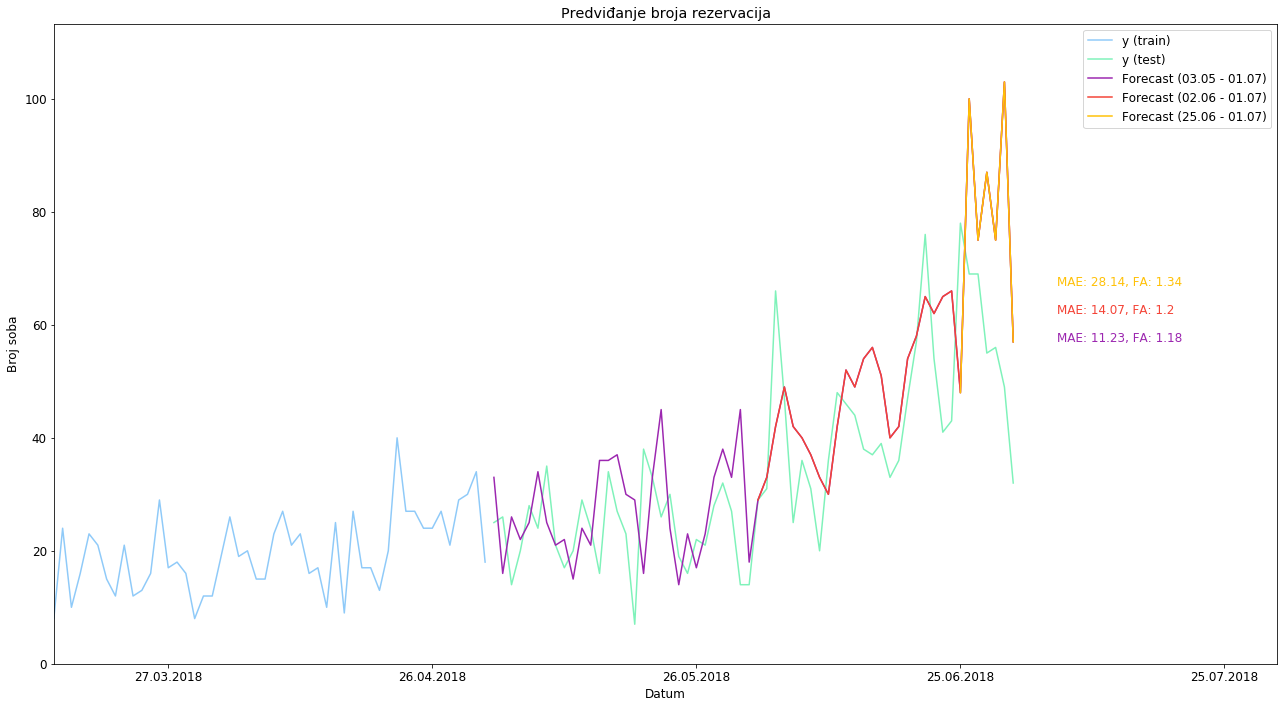

In [11]:
predictions = list()
for t, g in zip([train_60, train_30, train_7], [60, 30, 7]):
    p = t.y.values[-365:][:g]
    predictions.append({"gap": g, "predictions": p})
    
plot_predict(ts, predictions)

# Statistički modeli

In [12]:
# Ispitivanje stacionarnosti
adf = sm.tsa.stattools.adfuller(ts.y)
print("p-value: {0:.10f}".format(float(adf[1])))
# Null hipoteza je da TS nije stacionarna. 
# Ako je p < 0.05 onda se odbacuje null hipoteza i prihvaća se hipoteza da je TS stacionarna
# p-value y: 0.0007367938
# Zaključak: nije potrebno diferenciranje

p-value: 0.0007367938


### ACF

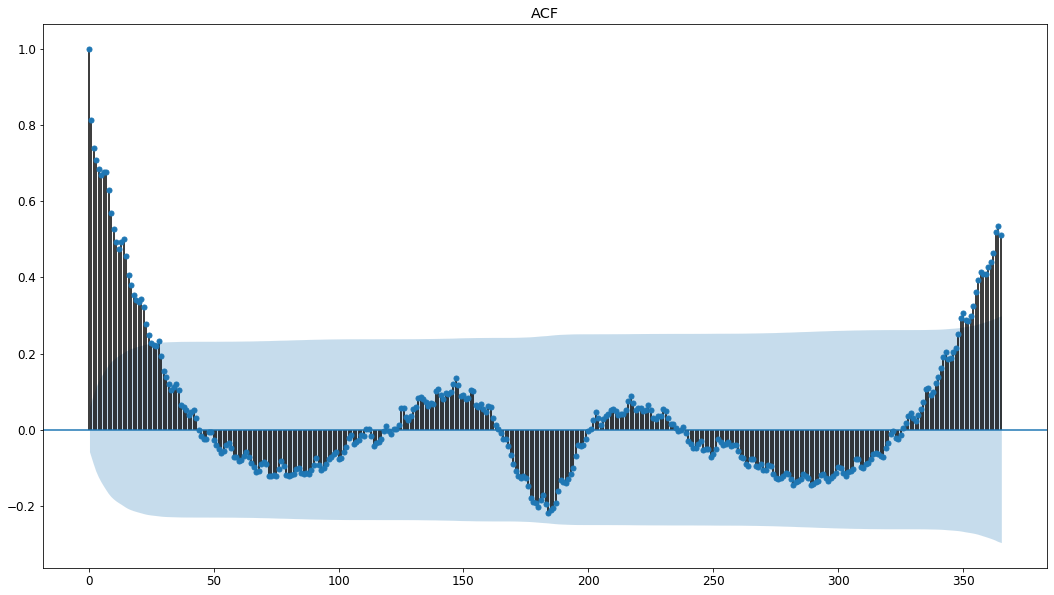

In [13]:
plot_acf(ts.y.values, lags=365, title="ACF", alpha=.05)
plt.rcParams["figure.figsize"] = (18, 10)
plt.show()

### PACF

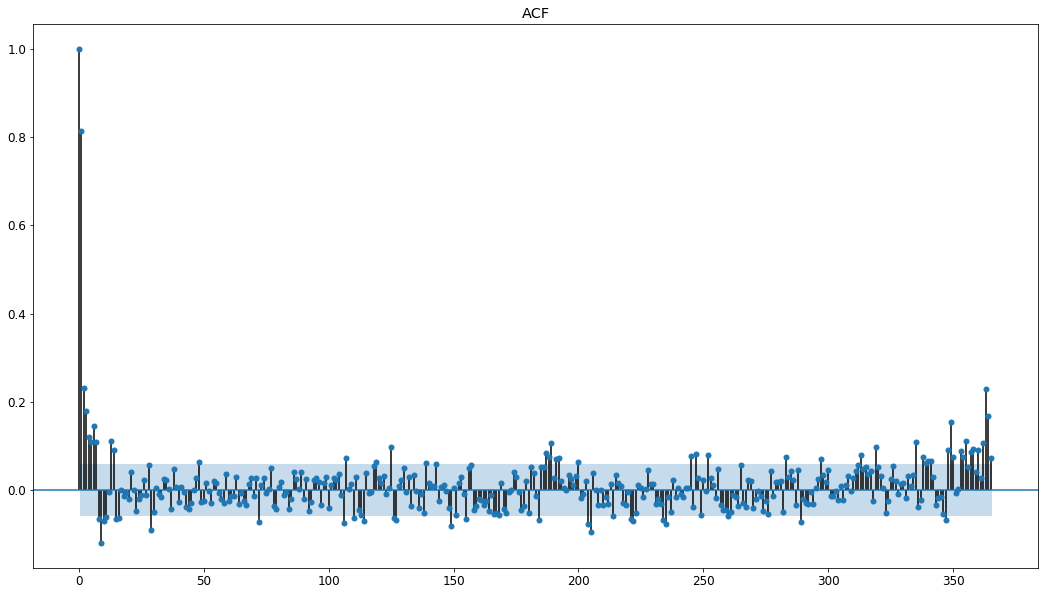

In [14]:
plot_pacf(ts.y.values, lags=365, title="ACF", alpha=.05)
plt.rcParams["figure.figsize"] = (18, 10)
plt.show()

## AR

In [15]:
model = ARIMA(train_60.y.values, order=(9, 0, 0))
model = model.fit(trend='nc')

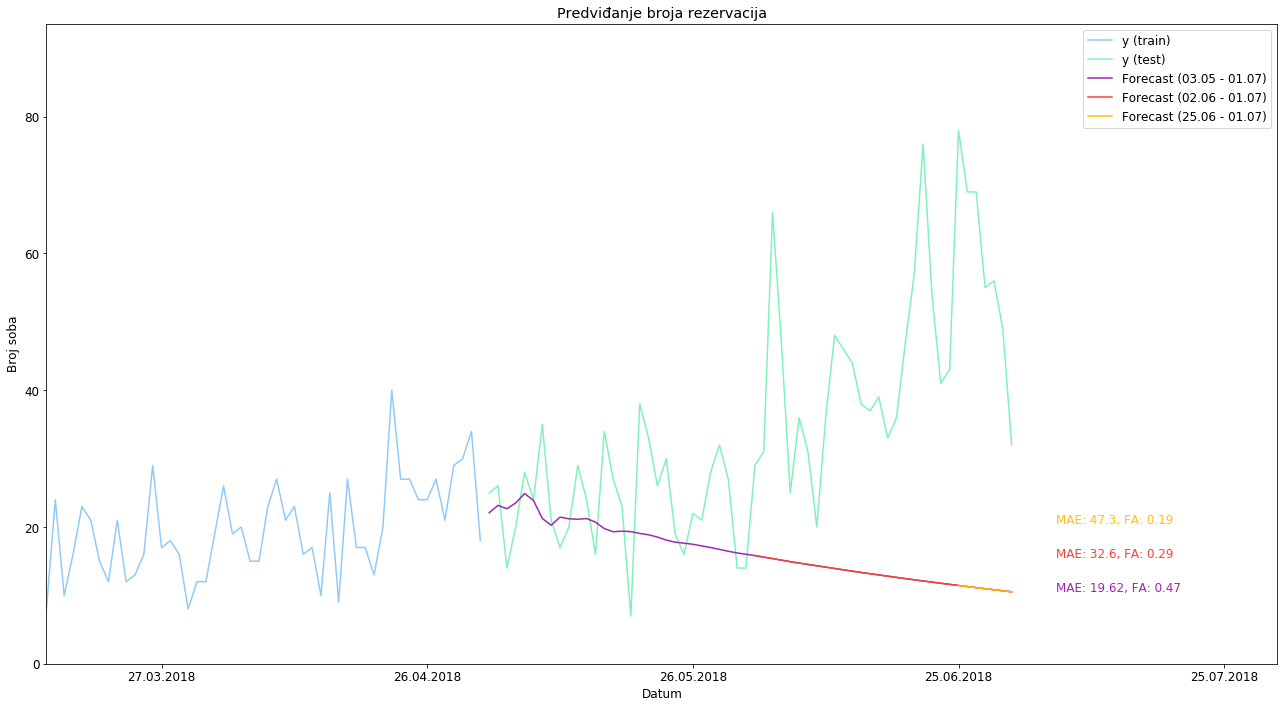

In [22]:
predictions = list()
for t, g in zip([train_60, train_30, train_7], [60, 30, 7]):
    p = model.predict(start=model.nobs, end=len(ts) - 1, dynamic=True)[-g:]
    predictions.append({"gap": g, "predictions": p})
    
plot_predict(ts, predictions)

## MA

In [23]:
model = ARIMA(train_60.y.values, order=(0, 0, 25))
model = model.fit(trend='nc')

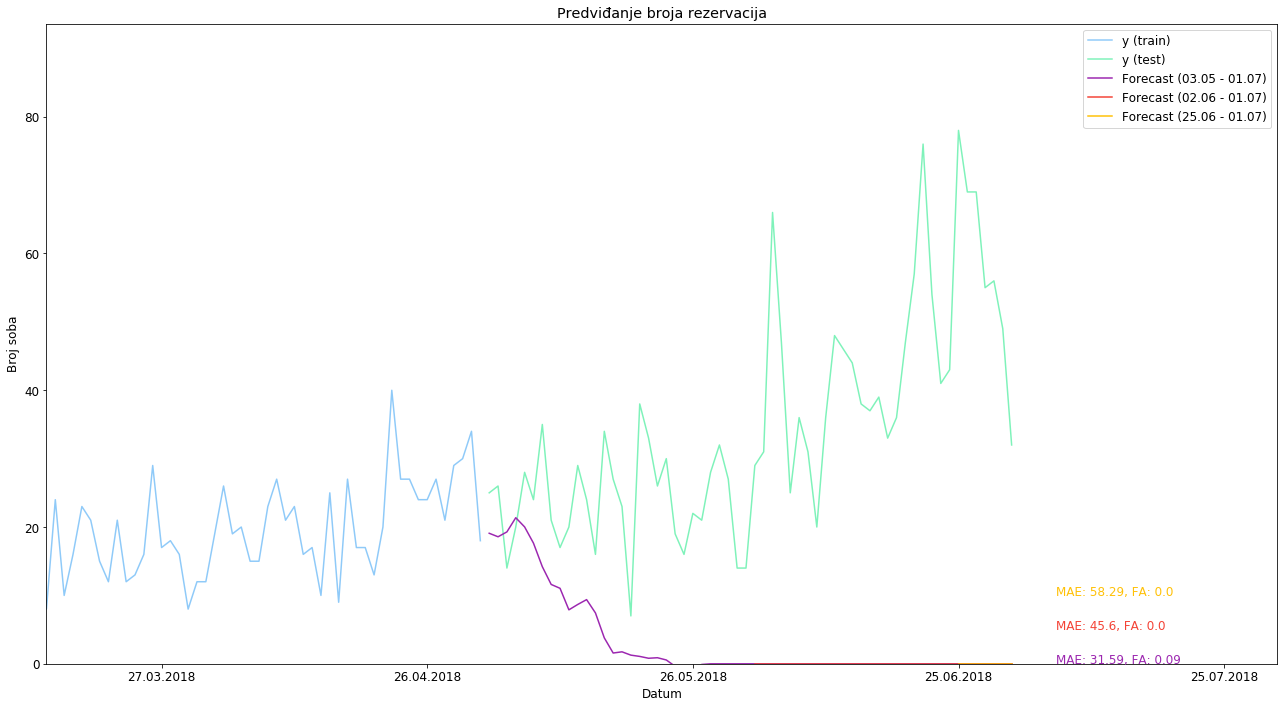

In [25]:
predictions = list()
for t, g in zip([train_60, train_30, train_7], [60, 30, 7]):
    p = model.predict(start=model.nobs, end=len(ts) - 1, dynamic=True)[-g:]
    predictions.append({"gap": g, "predictions": p})
    
plot_predict(ts, predictions)

## ARIMA

In [ ]:
model = ARIMA(train_60.y.values, order=(9, 0, 25))
model = model.fit(trend='nc')

In [ ]:
predictions = list()
for t, g in zip([train_60, train_30, train_7], [60, 30, 7]):
    p = model.predict(start=model.nobs, end=len(ts) - 1, dynamic=True)[-g:]
    predictions.append({"gap": g, "predictions": p})
    
plot_predict(ts, predictions)

## SARIMA

In [ ]:
model = SARIMAX(train_60.y.values,
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 365),
                trend='c',
                enforce_stationarity=False,
                enforce_invertibility=False)

model = model.fit(maxiter=1000, disp=False)

In [ ]:
predictions = list()
for t, g in zip([train_60, train_30, train_7], [60, 30, 7]):
    p = model.predict(start=model.nobs, end=len(ts) - 1, dynamic=True)[-g:]
    predictions.append({"gap": g, "predictions": p})
    
plot_predict(ts, predictions)

## Prophet

In [28]:
model = Prophet(seasonality_prior_scale=5,
                interval_width=.95,
                yearly_seasonality=True,
                weekly_seasonality=True)

model.add_country_holidays("HR")

model.fit(train_60.reset_index().rename(columns={'X': 'ds', 'y': 'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


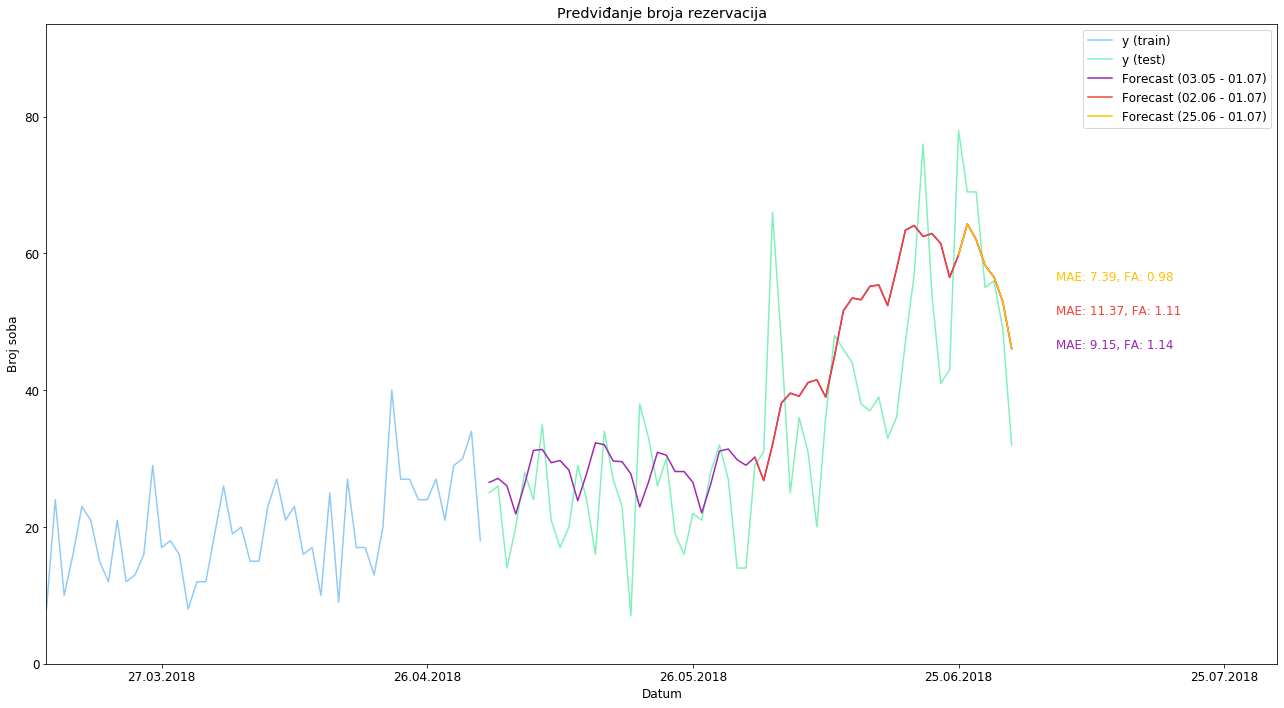

In [33]:
predictions = list()
for t, g in zip([train_60, train_30, train_7], [60, 30, 7]):
    
    test_ds = pd.DataFrame([t.index[-1] + datetime.timedelta(days=x) for x in range(0, g)], columns=["ds"])

    forecast = model.predict(df=test_ds)

    p = forecast.yhat.values
    
    predictions.append({"gap": g, "predictions": p})
    
plot_predict(ts, predictions)

# Neural Networks

In [62]:
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(np.array(ts.y.values).reshape(-1, 1))
nn_train = ts_scaled[:-60]
nn_test = ts_scaled[-60:]

In [63]:
def split_sequence(sequence, n_steps):
    
    X, y = list(), list()
    
    for i in range(len(sequence)):
        end_ix = i + n_steps

        if end_ix > len(sequence)-1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


def nn_predict(model, train, days, n_steps, scaler):
    
    predictions = list()
    while len(predictions) < days:

        start_idx = len(train) - n_steps + len(predictions)
        end_idx = len(train)

        if start_idx < end_idx:
            x_input = np.append(np.array(train[start_idx:end_idx]), np.array(predictions))
        else:
            x_input = np.array(predictions[len(predictions) - n_steps:len(predictions)])

        x_input = x_input.reshape(1, n_steps)

        yhat = model.predict(x_input, verbose=0).flatten()[0]

        predictions.append(yhat)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    return predictions[:days].flatten()

## MLP

In [47]:
n_steps = 300

model = Sequential()
model.add(Dense(500, activation='relu', input_dim=n_steps))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")

x, y = split_sequence(nn_train, n_steps)

x = x.reshape((x.shape[0], n_steps))

In [67]:
history = model.fit(x, y,
                    epochs=1000,
                    verbose=1,
                    batch_size=300,
                    shuffle=False)

Train on 736 samples
Epoch 1/1000
736/736 [==============================] - 0s 52us/sample - loss: 5.1323e-04
Epoch 2/1000
736/736 [==============================] - 0s 33us/sample - loss: 4.8901e-04
Epoch 3/1000
736/736 [==============================] - 0s 31us/sample - loss: 4.7950e-04
Epoch 4/1000
736/736 [==============================] - 0s 34us/sample - loss: 4.1728e-04
Epoch 5/1000
736/736 [==============================] - 0s 36us/sample - loss: 4.8621e-04
Epoch 6/1000
736/736 [==============================] - 0s 31us/sample - loss: 4.8890e-04
Epoch 7/1000
736/736 [==============================] - 0s 23us/sample - loss: 4.1541e-04
Epoch 8/1000
736/736 [==============================] - 0s 23us/sample - loss: 4.6554e-04
Epoch 9/1000
736/736 [==============================] - 0s 23us/sample - loss: 4.4263e-04
Epoch 10/1000
736/736 [==============================] - 0s 25us/sample - loss: 4.7764e-04
Epoch 11/1000
736/736 [==============================] - 0s 23us/sample - loss

736/736 [==============================] - 0s 26us/sample - loss: 3.6981e-04
Epoch 91/1000
736/736 [==============================] - 0s 25us/sample - loss: 4.0596e-04
Epoch 92/1000
736/736 [==============================] - 0s 24us/sample - loss: 3.6311e-04
Epoch 93/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.8299e-04
Epoch 94/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.9617e-04
Epoch 95/1000
736/736 [==============================] - 0s 22us/sample - loss: 4.0429e-04
Epoch 96/1000
736/736 [==============================] - 0s 25us/sample - loss: 4.1196e-04
Epoch 97/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.8609e-04
Epoch 98/1000
736/736 [==============================] - 0s 24us/sample - loss: 3.9710e-04
Epoch 99/1000
736/736 [==============================] - 0s 24us/sample - loss: 3.8328e-04
Epoch 100/1000
736/736 [==============================] - 0s 26us/sample - loss: 3.9935e-04
Epoch 101/10

736/736 [==============================] - 0s 22us/sample - loss: 3.5158e-04
Epoch 180/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.5530e-04
Epoch 181/1000
736/736 [==============================] - 0s 24us/sample - loss: 3.9710e-04
Epoch 182/1000
736/736 [==============================] - 0s 22us/sample - loss: 4.3569e-04
Epoch 183/1000
736/736 [==============================] - 0s 23us/sample - loss: 5.4306e-04
Epoch 184/1000
736/736 [==============================] - 0s 21us/sample - loss: 4.7865e-04
Epoch 185/1000
736/736 [==============================] - 0s 20us/sample - loss: 4.4565e-04
Epoch 186/1000
736/736 [==============================] - 0s 21us/sample - loss: 4.4597e-04
Epoch 187/1000
736/736 [==============================] - 0s 23us/sample - loss: 4.0363e-04
Epoch 188/1000
736/736 [==============================] - 0s 23us/sample - loss: 4.9109e-04
Epoch 189/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.7262e-04
Epo

736/736 [==============================] - 0s 20us/sample - loss: 4.7115e-04
Epoch 269/1000
736/736 [==============================] - 0s 21us/sample - loss: 4.4139e-04
Epoch 270/1000
736/736 [==============================] - 0s 20us/sample - loss: 4.3546e-04
Epoch 271/1000
736/736 [==============================] - 0s 22us/sample - loss: 6.1874e-04
Epoch 272/1000
736/736 [==============================] - 0s 22us/sample - loss: 4.9221e-04
Epoch 273/1000
736/736 [==============================] - 0s 21us/sample - loss: 3.9721e-04
Epoch 274/1000
736/736 [==============================] - 0s 21us/sample - loss: 4.9233e-04
Epoch 275/1000
736/736 [==============================] - 0s 20us/sample - loss: 4.2131e-04
Epoch 276/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.8722e-04
Epoch 277/1000
736/736 [==============================] - 0s 22us/sample - loss: 4.3739e-04
Epoch 278/1000
736/736 [==============================] - 0s 20us/sample - loss: 4.1595e-04
Epo

736/736 [==============================] - 0s 23us/sample - loss: 4.7643e-04
Epoch 358/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.9674e-04
Epoch 359/1000
736/736 [==============================] - 0s 24us/sample - loss: 4.4719e-04
Epoch 360/1000
736/736 [==============================] - 0s 23us/sample - loss: 4.0642e-04
Epoch 361/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.4672e-04
Epoch 362/1000
736/736 [==============================] - 0s 20us/sample - loss: 3.5931e-04
Epoch 363/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.2802e-04
Epoch 364/1000
736/736 [==============================] - 0s 21us/sample - loss: 3.0166e-04
Epoch 365/1000
736/736 [==============================] - 0s 19us/sample - loss: 3.2649e-04
Epoch 366/1000
736/736 [==============================] - 0s 21us/sample - loss: 4.2004e-04
Epoch 367/1000
736/736 [==============================] - 0s 20us/sample - loss: 3.9508e-04
Epo

736/736 [==============================] - 0s 22us/sample - loss: 3.8266e-04
Epoch 447/1000
736/736 [==============================] - 0s 25us/sample - loss: 3.7543e-04
Epoch 448/1000
736/736 [==============================] - 0s 25us/sample - loss: 3.5298e-04
Epoch 449/1000
736/736 [==============================] - 0s 23us/sample - loss: 4.0854e-04
Epoch 450/1000
736/736 [==============================] - 0s 25us/sample - loss: 3.5199e-04
Epoch 451/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.3217e-04
Epoch 452/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.1734e-04
Epoch 453/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.6780e-04
Epoch 454/1000
736/736 [==============================] - 0s 21us/sample - loss: 3.4641e-04
Epoch 455/1000
736/736 [==============================] - 0s 24us/sample - loss: 4.1887e-04
Epoch 456/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.8503e-04
Epo

736/736 [==============================] - 0s 22us/sample - loss: 3.8851e-04
Epoch 535/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.4393e-04
Epoch 536/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.2654e-04
Epoch 537/1000
736/736 [==============================] - 0s 20us/sample - loss: 3.9868e-04
Epoch 538/1000
736/736 [==============================] - 0s 21us/sample - loss: 3.5187e-04
Epoch 539/1000
736/736 [==============================] - 0s 21us/sample - loss: 3.6908e-04
Epoch 540/1000
736/736 [==============================] - 0s 21us/sample - loss: 3.9277e-04
Epoch 541/1000
736/736 [==============================] - 0s 20us/sample - loss: 3.5955e-04
Epoch 542/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.9017e-04
Epoch 543/1000
736/736 [==============================] - 0s 21us/sample - loss: 4.3358e-04
Epoch 544/1000
736/736 [==============================] - 0s 23us/sample - loss: 4.2270e-04
Epo

736/736 [==============================] - 0s 24us/sample - loss: 3.2886e-04
Epoch 623/1000
736/736 [==============================] - 0s 25us/sample - loss: 3.6861e-04
Epoch 624/1000
736/736 [==============================] - 0s 24us/sample - loss: 3.8338e-04
Epoch 625/1000
736/736 [==============================] - 0s 21us/sample - loss: 3.3682e-04
Epoch 626/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.5355e-04
Epoch 627/1000
736/736 [==============================] - 0s 21us/sample - loss: 3.3502e-04
Epoch 628/1000
736/736 [==============================] - 0s 23us/sample - loss: 4.3875e-04
Epoch 629/1000
736/736 [==============================] - 0s 22us/sample - loss: 4.0125e-04
Epoch 630/1000
736/736 [==============================] - 0s 24us/sample - loss: 3.7977e-04
Epoch 631/1000
736/736 [==============================] - 0s 24us/sample - loss: 3.8271e-04
Epoch 632/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.4206e-04
Epo

736/736 [==============================] - 0s 23us/sample - loss: 2.8916e-04
Epoch 712/1000
736/736 [==============================] - 0s 24us/sample - loss: 2.9428e-04
Epoch 713/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.4614e-04
Epoch 714/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.1243e-04
Epoch 715/1000
736/736 [==============================] - 0s 23us/sample - loss: 2.9153e-04
Epoch 716/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.2805e-04
Epoch 717/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.2463e-04
Epoch 718/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.1397e-04
Epoch 719/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.1726e-04
Epoch 720/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.0433e-04
Epoch 721/1000
736/736 [==============================] - 0s 21us/sample - loss: 3.5064e-04
Epo

736/736 [==============================] - 0s 23us/sample - loss: 3.3106e-04
Epoch 801/1000
736/736 [==============================] - 0s 24us/sample - loss: 3.2493e-04
Epoch 802/1000
736/736 [==============================] - 0s 24us/sample - loss: 3.5033e-04
Epoch 803/1000
736/736 [==============================] - 0s 23us/sample - loss: 2.4331e-04
Epoch 804/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.4180e-04
Epoch 805/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.1251e-04
Epoch 806/1000
736/736 [==============================] - 0s 24us/sample - loss: 3.4208e-04
Epoch 807/1000
736/736 [==============================] - 0s 24us/sample - loss: 4.0018e-04
Epoch 808/1000
736/736 [==============================] - 0s 22us/sample - loss: 2.6370e-04
Epoch 809/1000
736/736 [==============================] - 0s 24us/sample - loss: 3.3115e-04
Epoch 810/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.0663e-04
Epo

736/736 [==============================] - 0s 22us/sample - loss: 3.3016e-04
Epoch 890/1000
736/736 [==============================] - 0s 22us/sample - loss: 2.9861e-04
Epoch 891/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.4231e-04
Epoch 892/1000
736/736 [==============================] - 0s 20us/sample - loss: 2.9068e-04
Epoch 893/1000
736/736 [==============================] - 0s 22us/sample - loss: 2.9649e-04
Epoch 894/1000
736/736 [==============================] - 0s 21us/sample - loss: 3.1741e-04
Epoch 895/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.2175e-04
Epoch 896/1000
736/736 [==============================] - 0s 24us/sample - loss: 3.1553e-04
Epoch 897/1000
736/736 [==============================] - 0s 27us/sample - loss: 3.2861e-04
Epoch 898/1000
736/736 [==============================] - 0s 27us/sample - loss: 2.9920e-04
Epoch 899/1000
736/736 [==============================] - 0s 27us/sample - loss: 3.2484e-04
Epo

736/736 [==============================] - 0s 22us/sample - loss: 3.1733e-04
Epoch 979/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.3774e-04
Epoch 980/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.0856e-04
Epoch 981/1000
736/736 [==============================] - 0s 22us/sample - loss: 2.9643e-04
Epoch 982/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.7284e-04
Epoch 983/1000
736/736 [==============================] - 0s 22us/sample - loss: 2.7086e-04
Epoch 984/1000
736/736 [==============================] - 0s 23us/sample - loss: 3.0939e-04
Epoch 985/1000
736/736 [==============================] - 0s 22us/sample - loss: 2.7799e-04
Epoch 986/1000
736/736 [==============================] - 0s 22us/sample - loss: 3.8507e-04
Epoch 987/1000
736/736 [==============================] - 0s 21us/sample - loss: 2.9004e-04
Epoch 988/1000
736/736 [==============================] - 0s 22us/sample - loss: 2.8811e-04
Epo

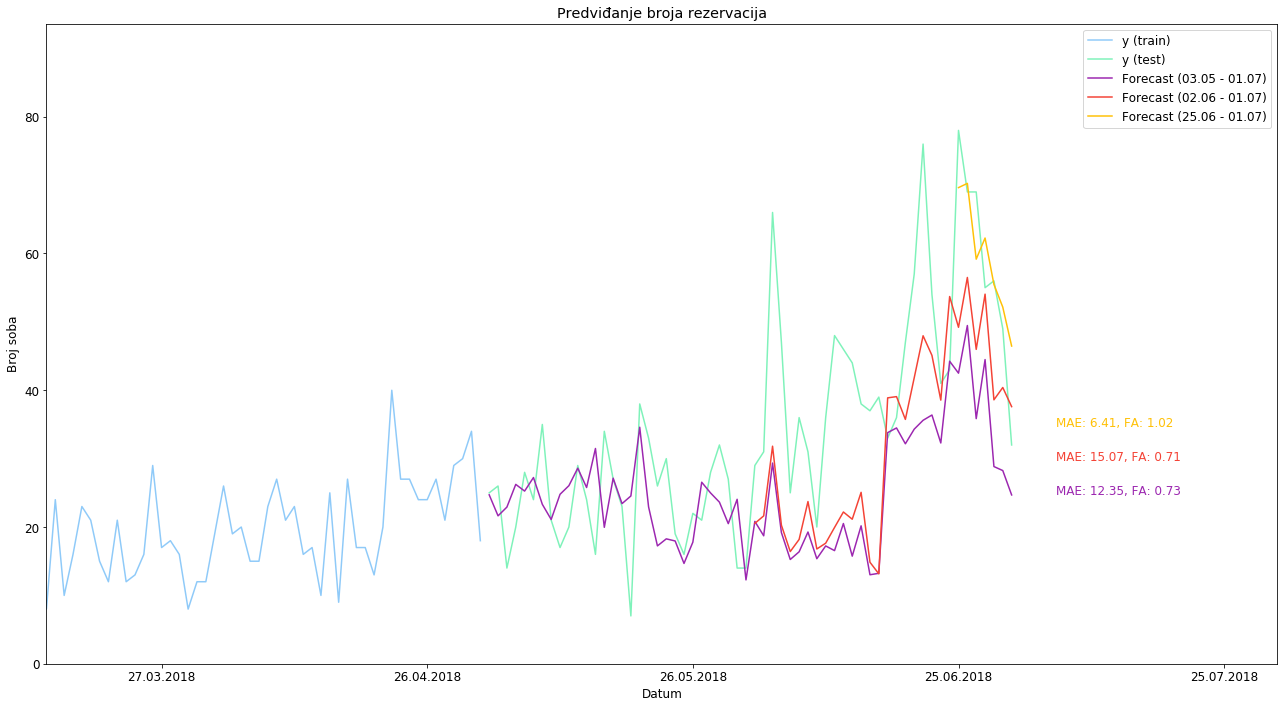

In [68]:
p_60 = nn_predict(model, ts_scaled[:-60], 60, n_steps, scaler)
p_30 = nn_predict(model, ts_scaled[:-30], 30, n_steps, scaler)
p_7 = nn_predict(model, ts_scaled[:-7], 7, n_steps, scaler)

predictions = list()
predictions.append({"gap": 60, "predictions": p_60})
predictions.append({"gap": 30, "predictions": p_30})
predictions.append({"gap": 7, "predictions": p_7})
plot_predict(ts, predictions)